In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

SEEDS = [40, 41, 43, 44, 45, 46, 47, 48, 49, 50]
TEST_SPLIT_SEED = 40

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


In [20]:
CSV_PATH = "wildfire_preprocessed_V1.csv"        # ← 파일명/경로 맞게 수정
TARGET   = "FIRE_SUPESN_HR"   # ← 타깃 컬럼명 맞게 수정

df = pd.read_csv(CSV_PATH)
print("[STEP0] 데이터 로드:", df.shape)
display(df.head(10))

X = df.drop(columns=[TARGET])
y = df[TARGET].values


[STEP0] 데이터 로드: (3359, 66)


,DSPT_REQ_HR,FIRE_SUPESN_HR,FRSTN_GRNDS_DSTNC,CNTR_GRNDS_DSTNC,HR_UNIT_ARTMP,HR_UNIT_HUM,WSPD_BIN,MONTH,CMBS_EXPOBJ_LCLSF_NM_unknown,CMBS_EXPOBJ_LCLSF_NM_GAS,...,WNDRCT_BRNG_west,WNDRCT_BRNG_남동,WNDRCT_BRNG_남서,WNDRCT_BRNG_북동,WNDRCT_BRNG_북서,dispatch_time_diff,arrival_time_diff,golden_time_under_50min,is_night,month_rcpt
0,5.509388,7.090910,2.484907,1.609438,-1.0,39.0,1,1,0,0,...,0,0,0,0,1,4.521789,5.823046,1,1,1
1,5.537334,6.398595,1.609438,1.098612,5.0,60.0,1,3,0,0,...,0,0,1,0,0,3.663562,5.676754,1,1,3
2,6.467699,7.284821,2.302585,1.791759,7.0,49.0,1,3,0,0,...,0,0,1,0,0,3.526361,6.517671,1,1,3
3,6.361302,7.333023,1.791759,1.098612,0.3,48.0,3,3,0,0,...,0,0,0,0,1,4.077537,6.456770,1,0,3
4,6.774224,9.579487,3.295837,2.397895,-8.7,36.0,5,12,0,0,...,1,0,0,0,0,3.496508,6.810142,1,1,12
5,6.338594,9.894396,3.367296,2.197225,2.3,38.0,1,12,0,0,...,0,0,0,0,1,5.298317,6.639876,1,0,12
6,6.476972,8.777093,1.791759,2.079442,-2.9,36.0,5,12,0,0,...,0,0,1,0,0,3.737670,6.538140,1,1,12
7,6.089045,8.806724,3.178054,2.564949,-1.2,89.0,1,1,0,0,...,0,0,0,1,0,1.945910,6.102559,1,0,1
8,5.749393,0.000000,2.197225,0.693147,10.2,35.0,1,12,0,0,...,1,0,0,0,0,4.343805,5.966147,1,0,12
9,7.049255,8.601167,3.178054,2.772589,12.9,26.0,1,12,0,0,...,0,0,0,0,1,3.044522,7.066467,1,0,12



[STEP1] EDA 요약
자료형 요약:
int64      58
float64     8
Name: count, dtype: int64 

기초통계(숫자형):


,count,mean,std,min,25%,50%,75%,max
DSPT_REQ_HR,3359.0,6.347238,0.630339,0.0,5.888878,6.364751,6.776507,9.709235
FIRE_SUPESN_HR,3359.0,8.052170,1.442208,0.0,7.376508,8.175829,8.865947,11.354211
FRSTN_GRNDS_DSTNC,3359.0,2.610196,0.739633,0.0,2.197225,2.708050,3.135494,4.605170
CNTR_GRNDS_DSTNC,3359.0,1.988543,0.786945,0.0,1.386294,2.079442,2.564949,4.317488
HR_UNIT_ARTMP,3359.0,13.122715,8.507974,-15.3,7.200000,13.500000,19.200000,36.000000
...,...,...,...,...,...,...,...,...
dispatch_time_diff,3359.0,4.070910,0.980141,0.0,3.850148,4.143135,4.532599,8.665441
arrival_time_diff,3359.0,6.491795,0.579521,0.0,6.049733,6.490724,6.859615,11.385910
golden_time_under_50min,3359.0,0.993153,0.082477,0.0,1.000000,1.000000,1.000000,1.000000
is_night,3359.0,0.123549,0.329115,0.0,0.000000,0.000000,0.000000,1.000000


결측치 Top10:


DSPT_REQ_HR                 0
FND_IGTN_PSTN_NM_unknown    0
CTPV_NM_gyeongbuk           0
CTPV_NM_gyeonggi            0
CTPV_NM_gyeongnam           0
CTPV_NM_incheon             0
CTPV_NM_jeju                0
CTPV_NM_jeonbuk             0
CTPV_NM_jeonnam             0
CTPV_NM_sejong              0
dtype: int64


수치형 변수 히스토그램


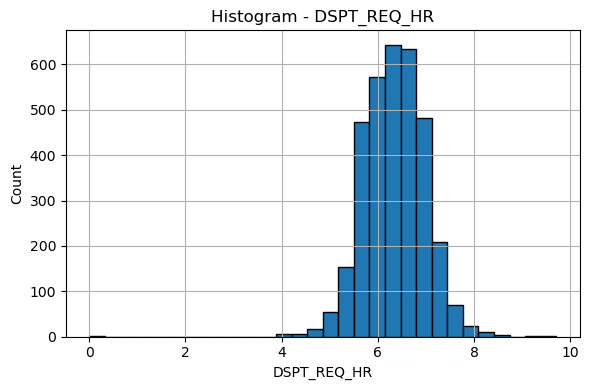

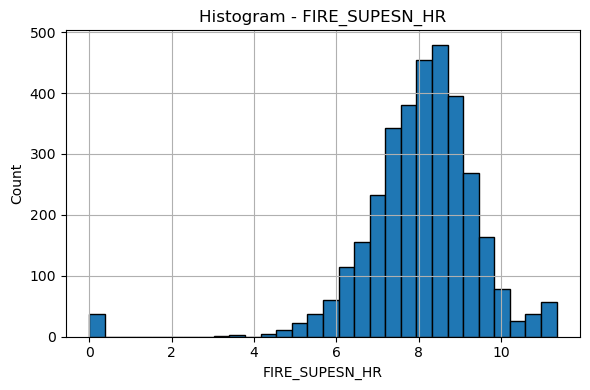

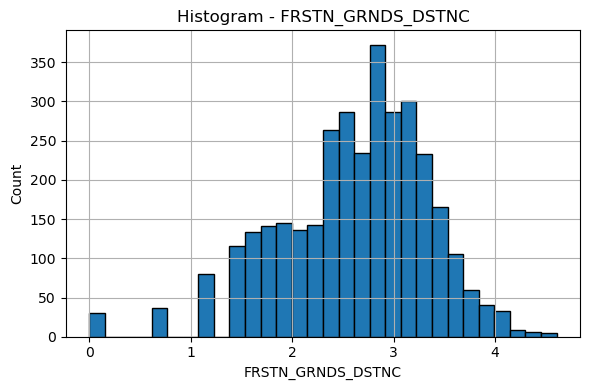

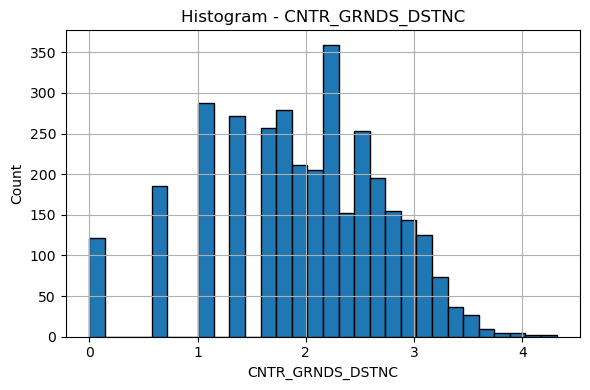

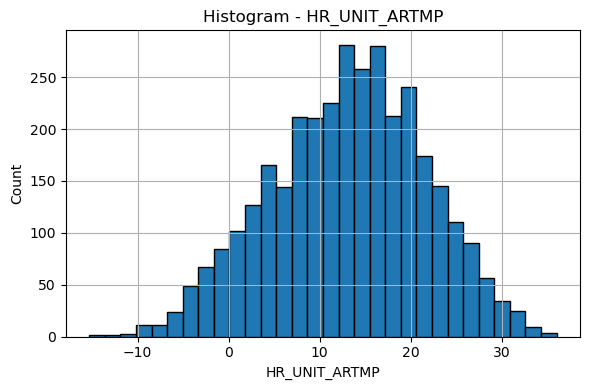

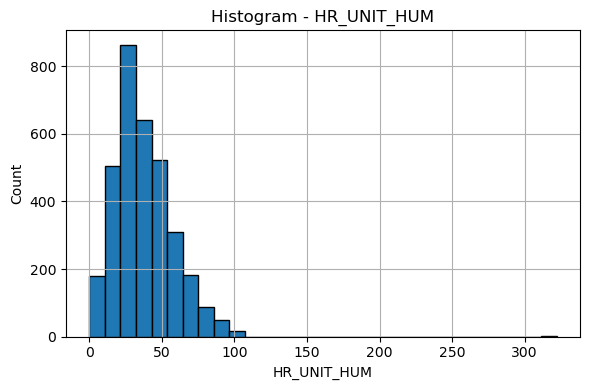

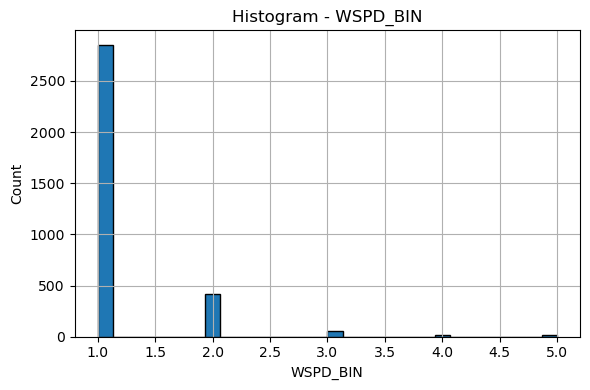

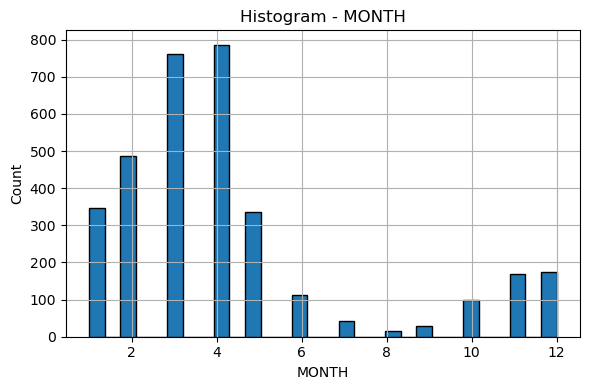

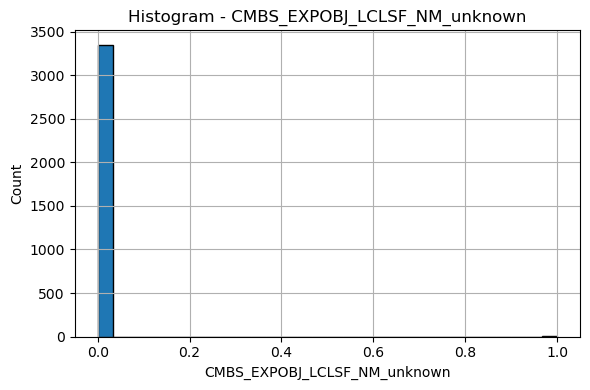

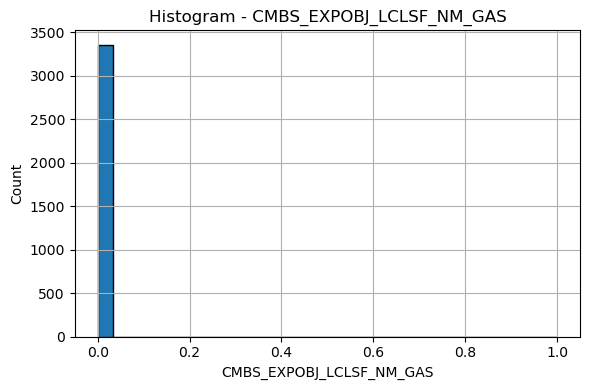

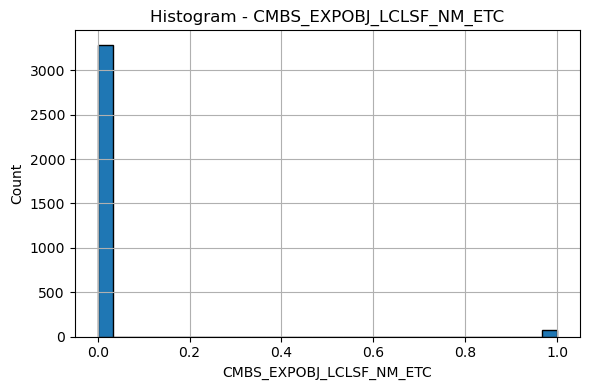

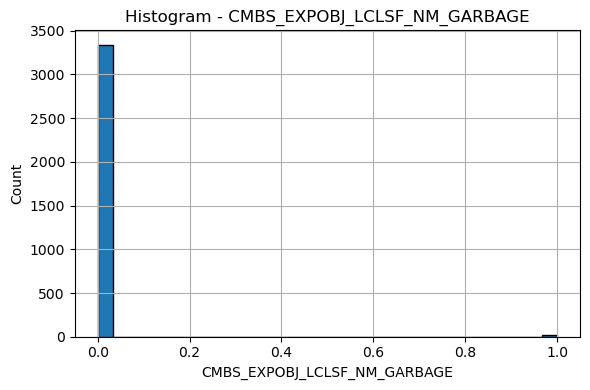

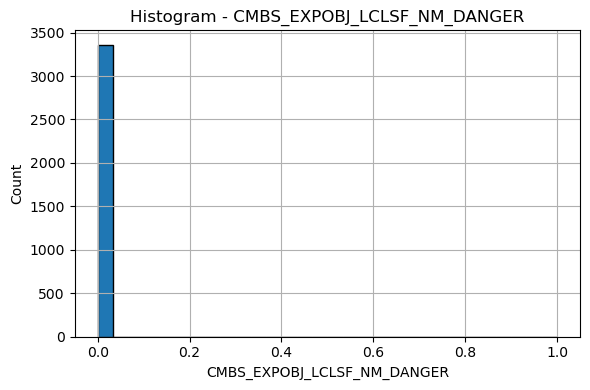

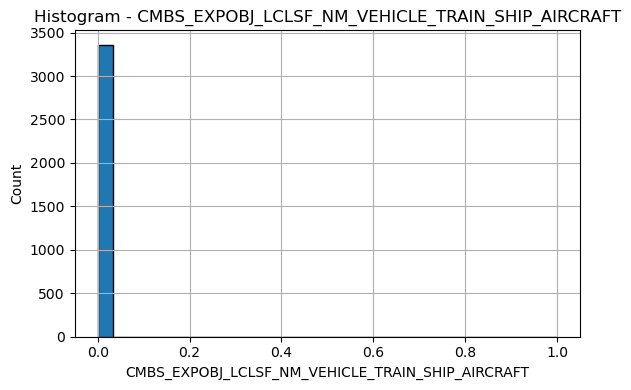

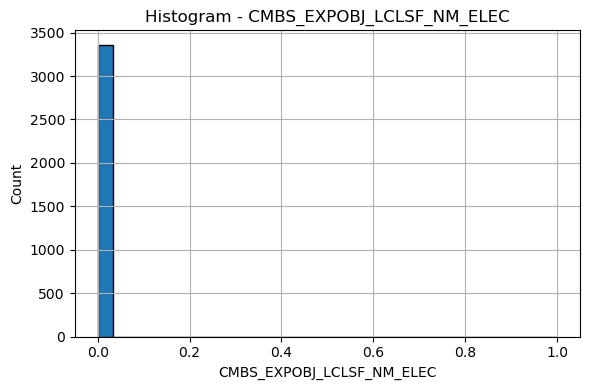

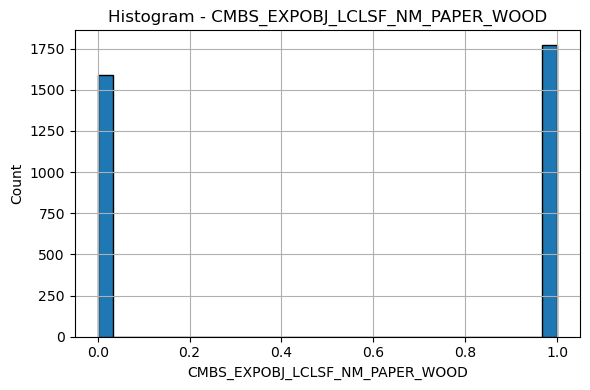

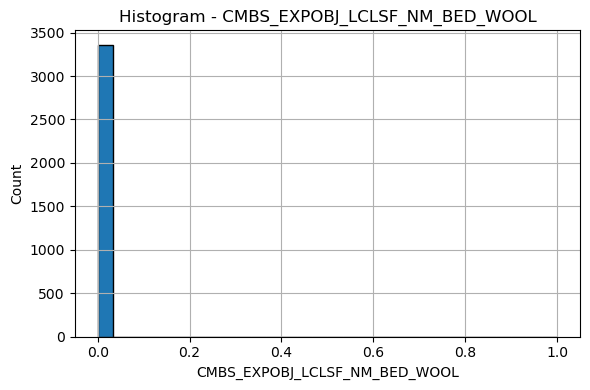

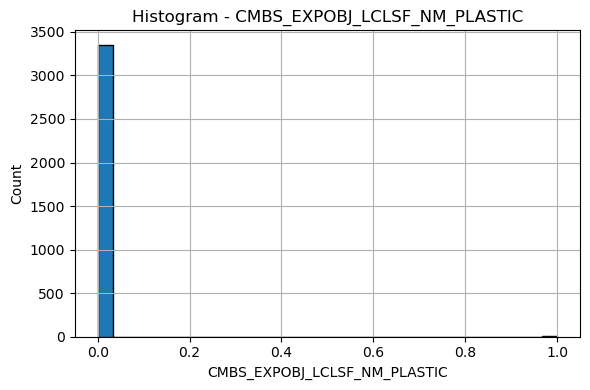

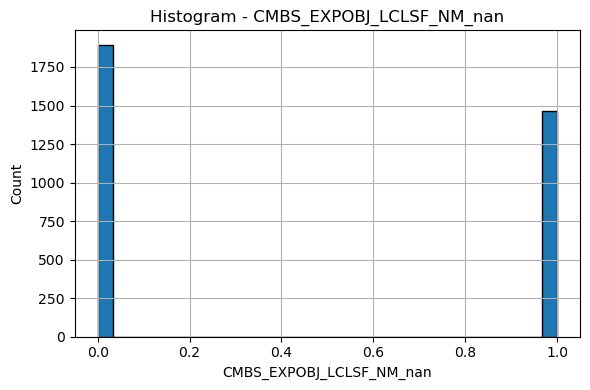

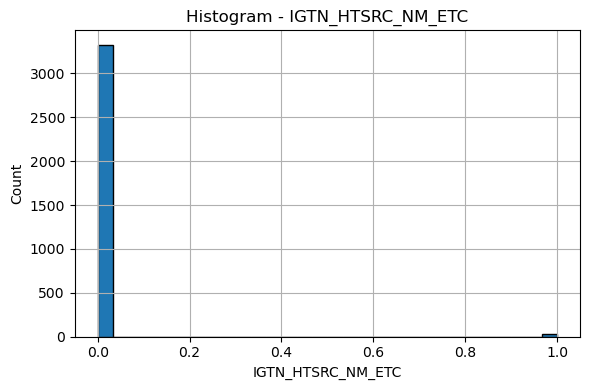

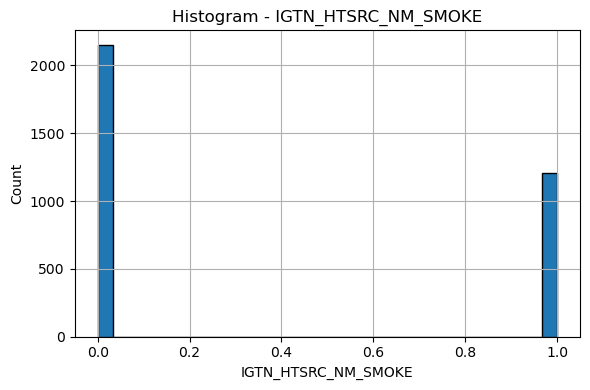

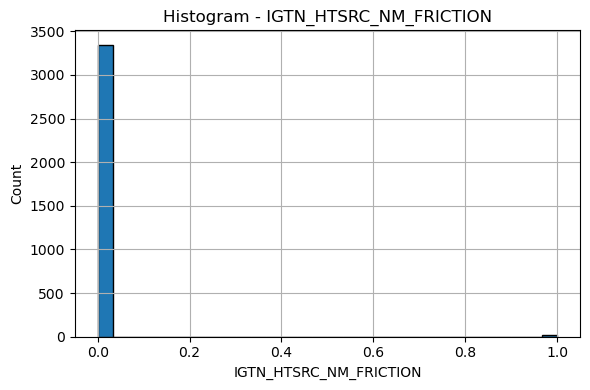

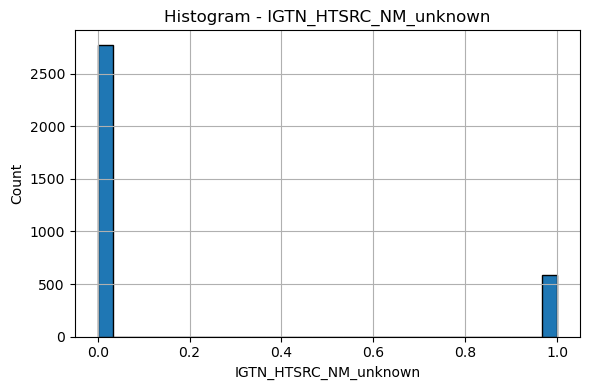

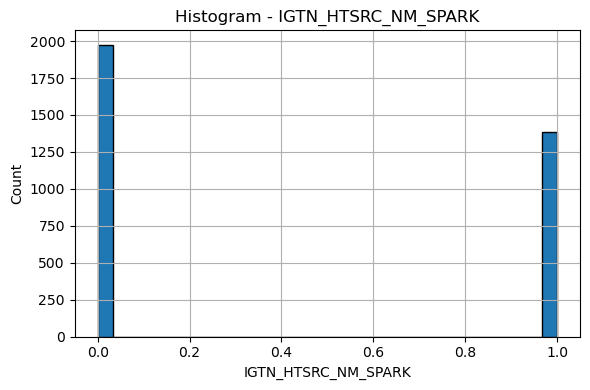

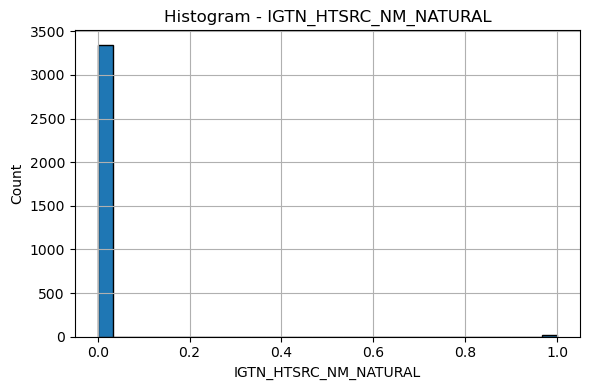

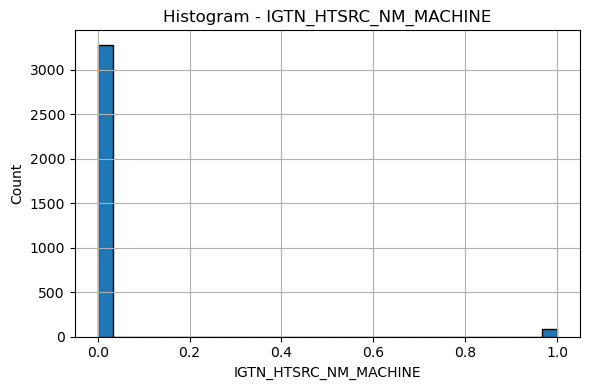

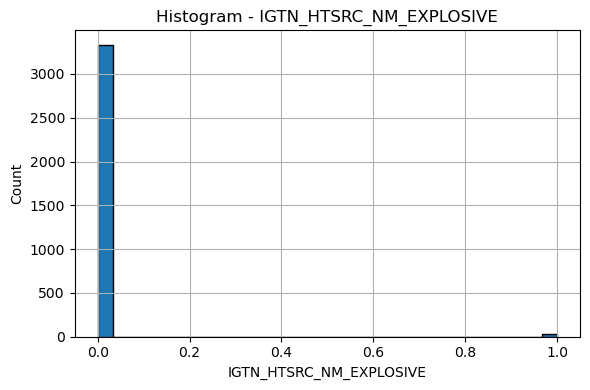

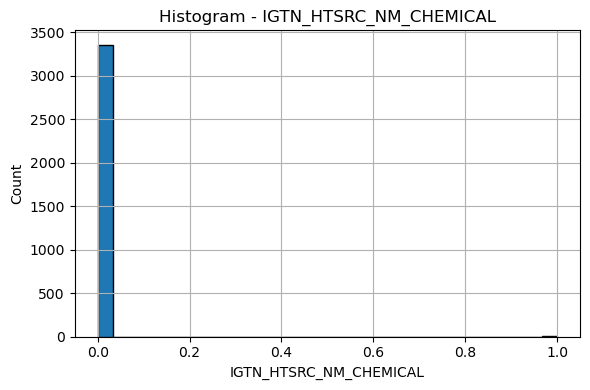

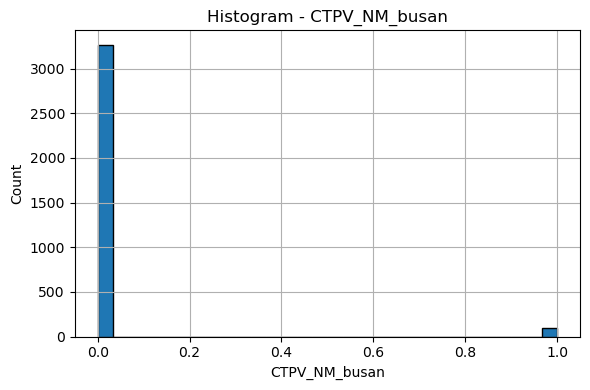

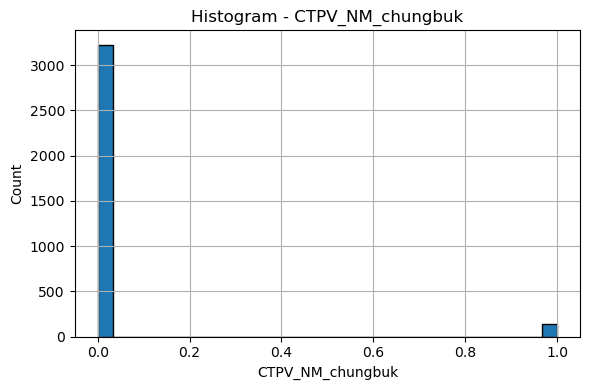

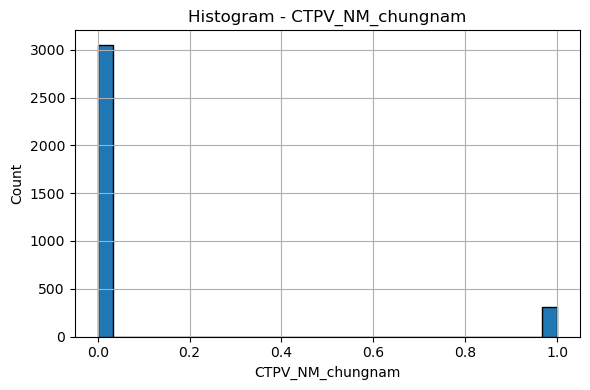

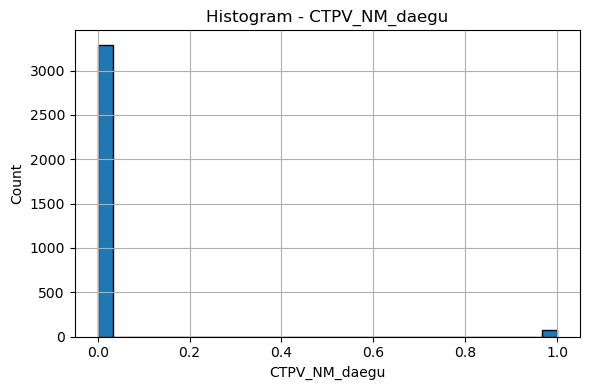

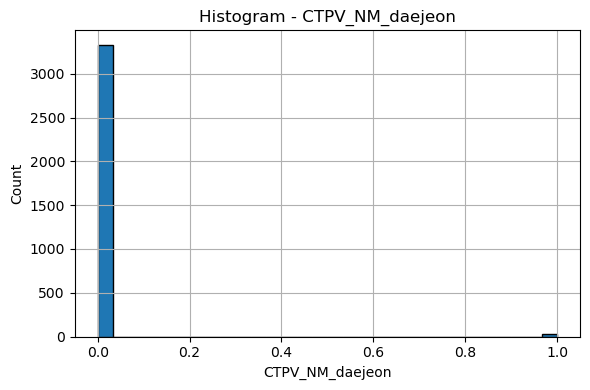

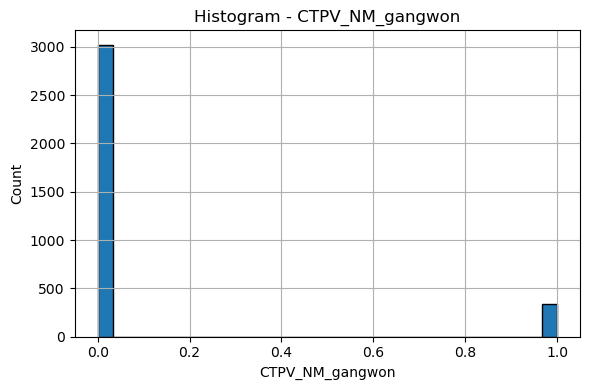

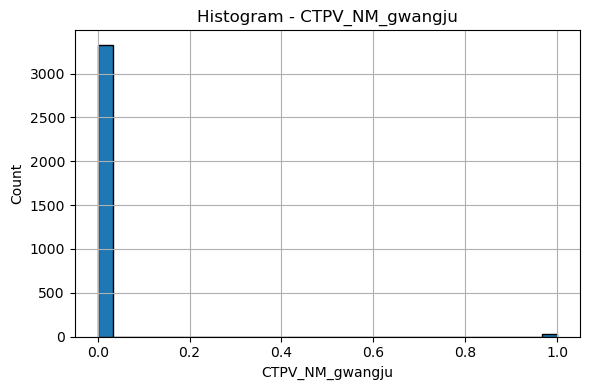

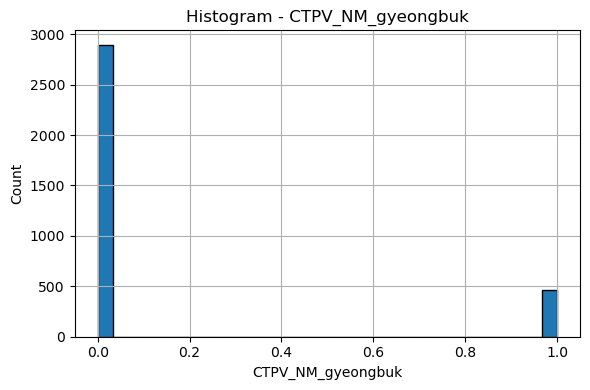

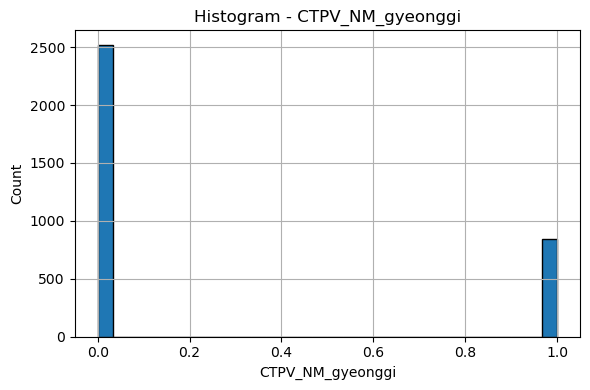

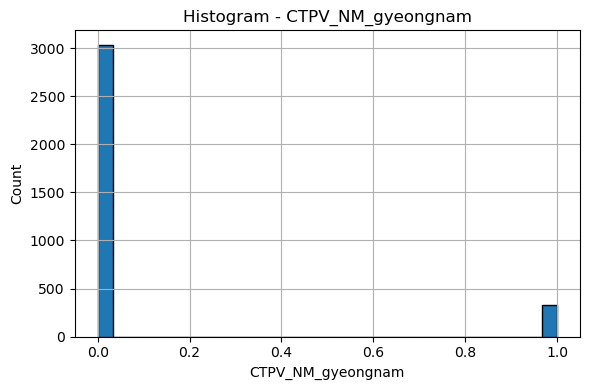

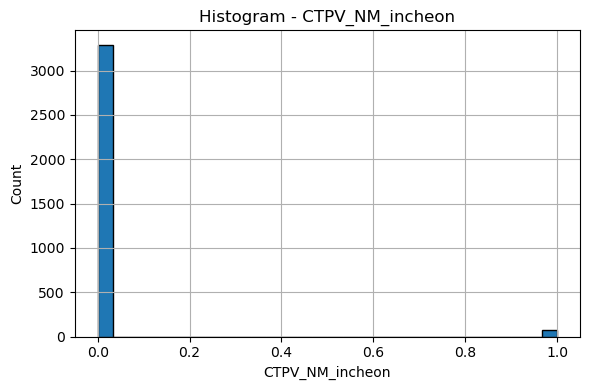

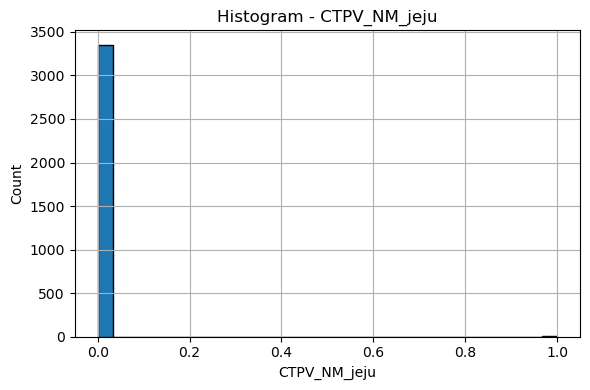

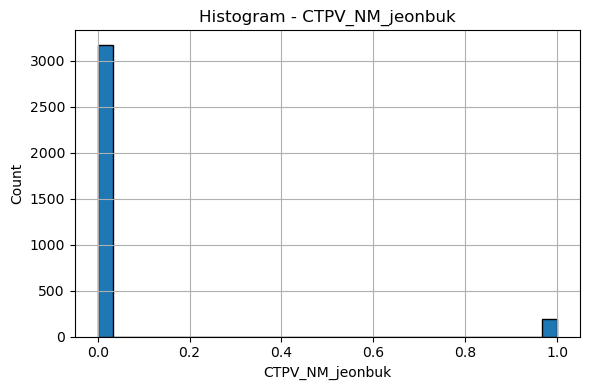

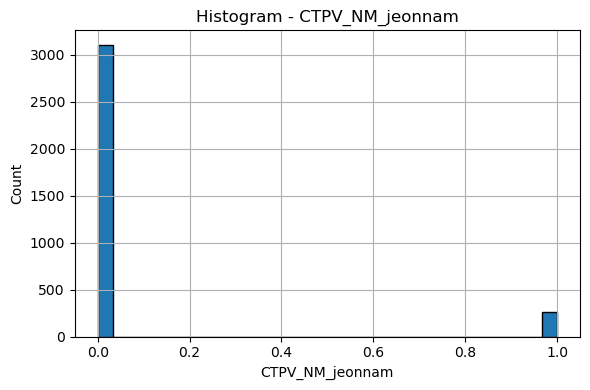

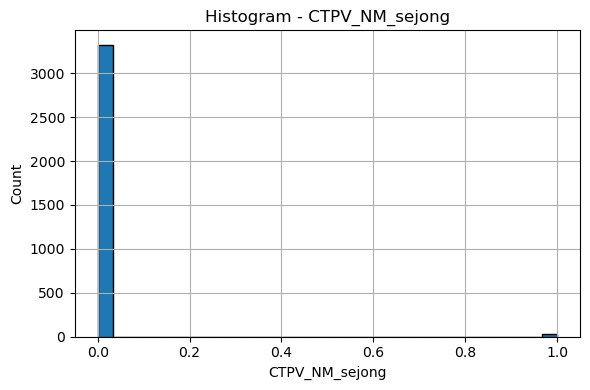

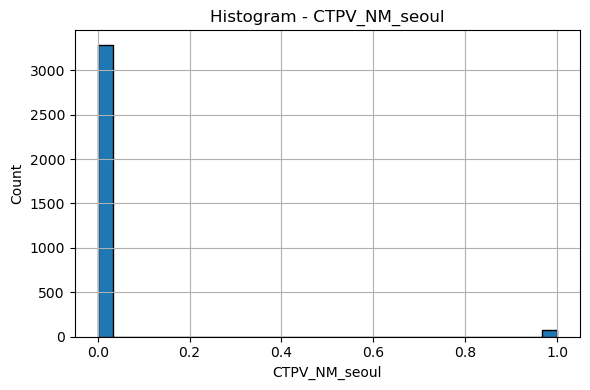

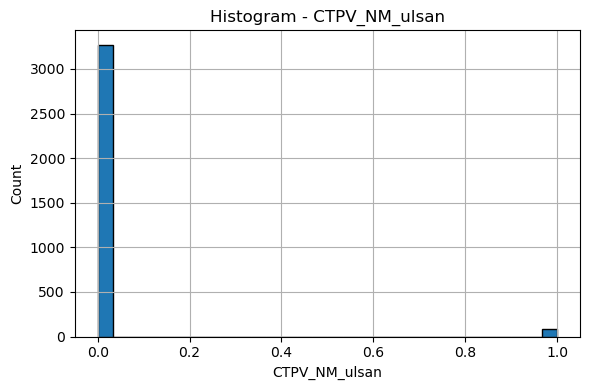

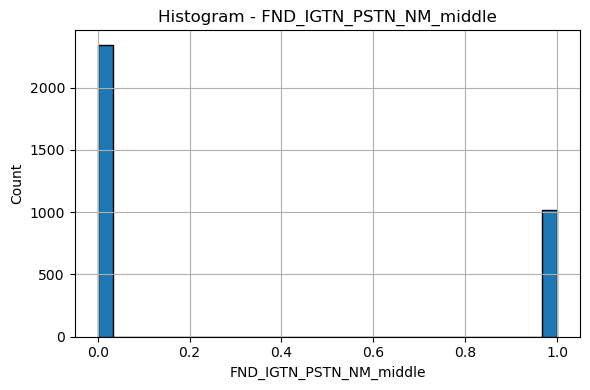

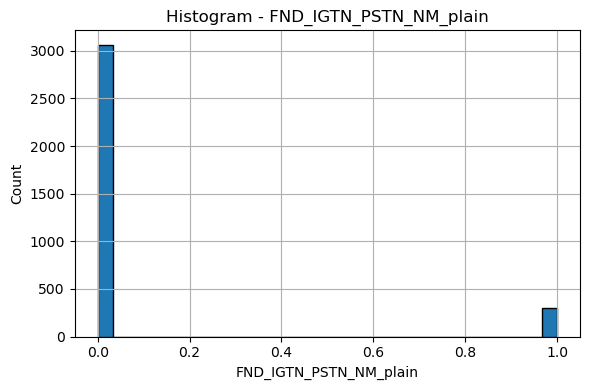

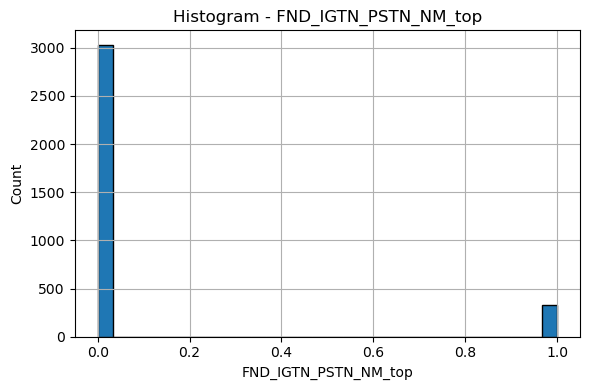

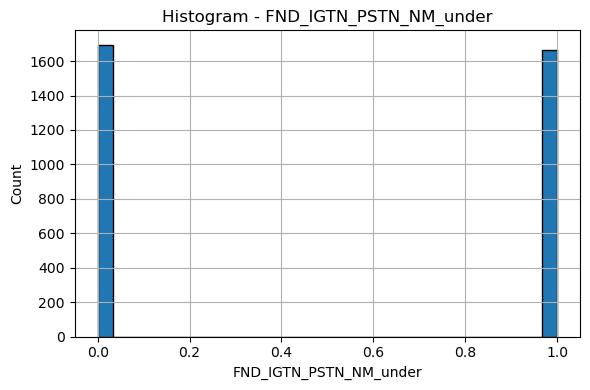

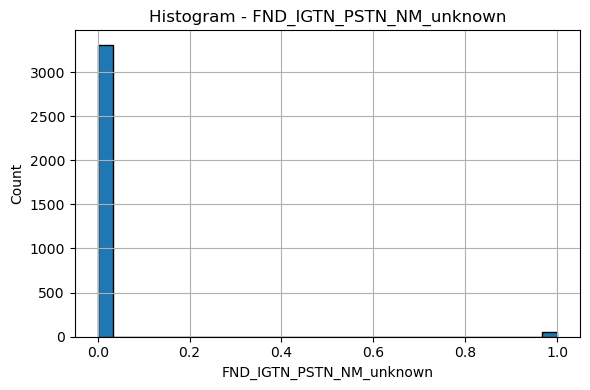

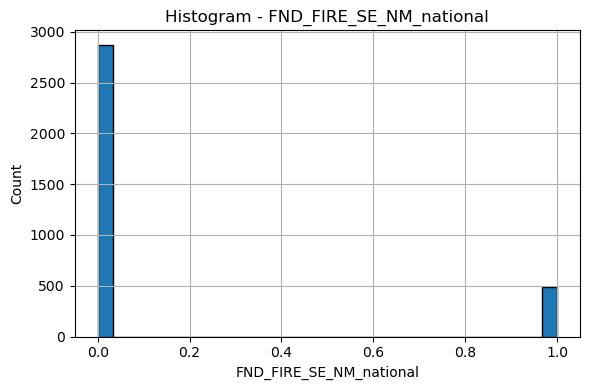

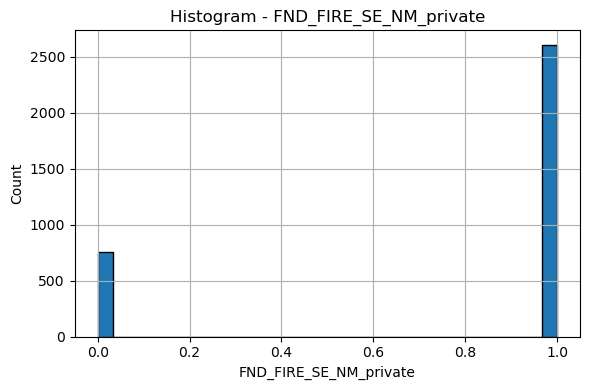

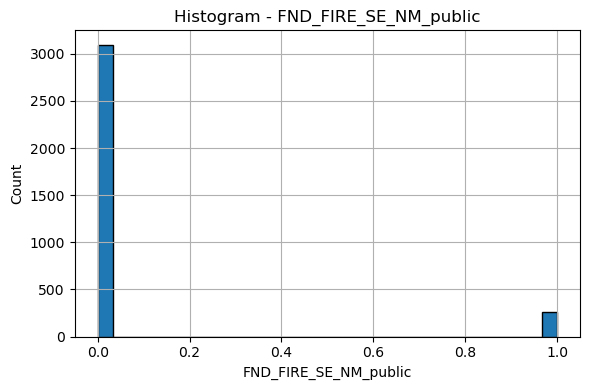

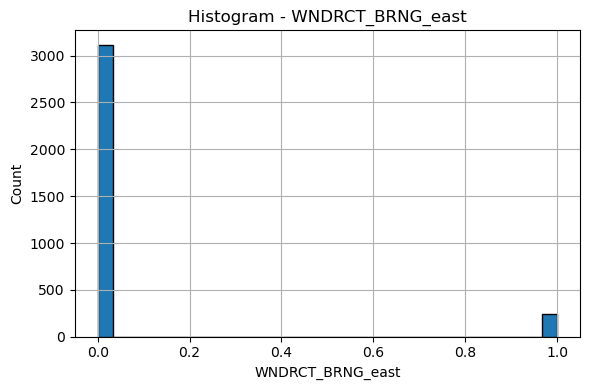

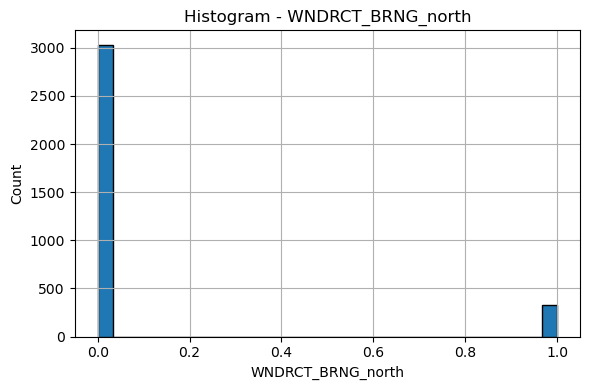

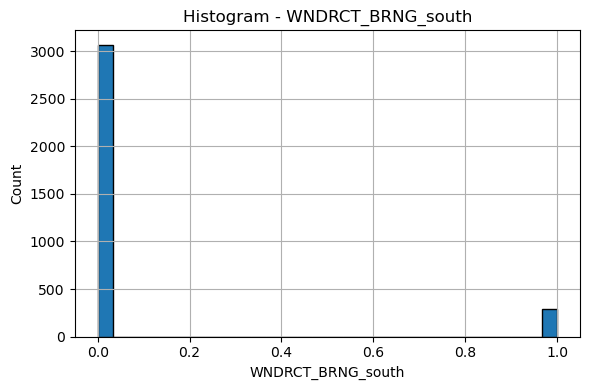

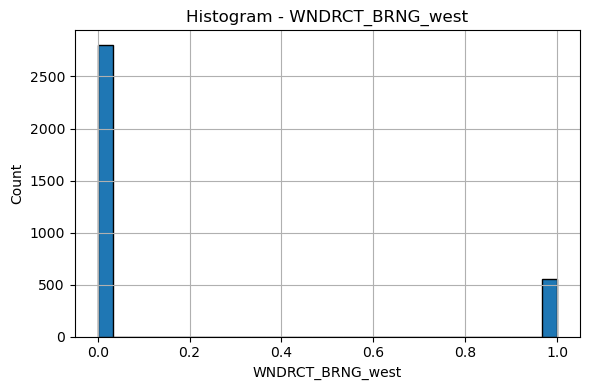

/var/folders/hf/h25ltg5j66b_wj4155m7sffm0000gn/T/ipykernel_1002/1614274061.py:22: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/hf/h25ltg5j66b_wj4155m7sffm0000gn/T/ipykernel_1002/1614274061.py:22: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


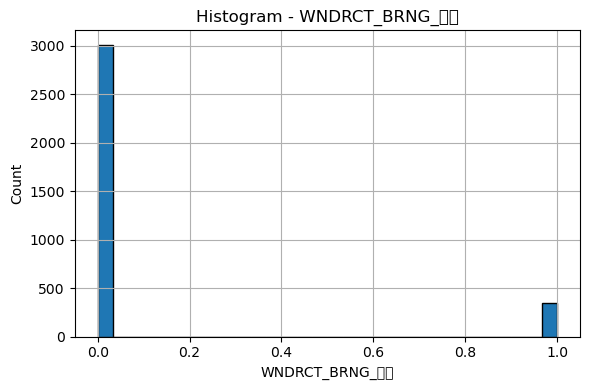

/var/folders/hf/h25ltg5j66b_wj4155m7sffm0000gn/T/ipykernel_1002/1614274061.py:22: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


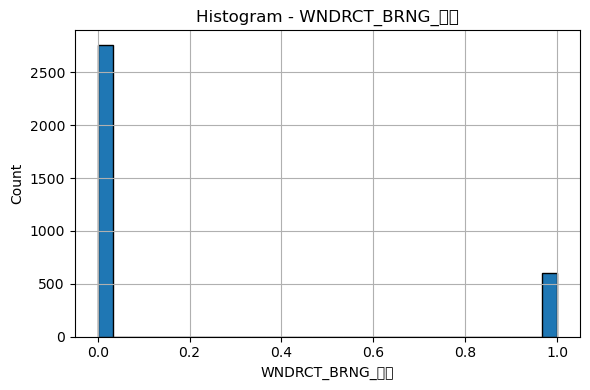

/var/folders/hf/h25ltg5j66b_wj4155m7sffm0000gn/T/ipykernel_1002/1614274061.py:22: UserWarning: Glyph 48513 (\N{HANGUL SYLLABLE BUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48513 (\N{HANGUL SYLLABLE BUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


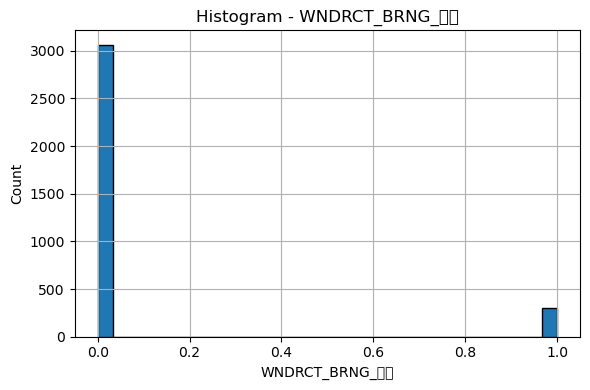

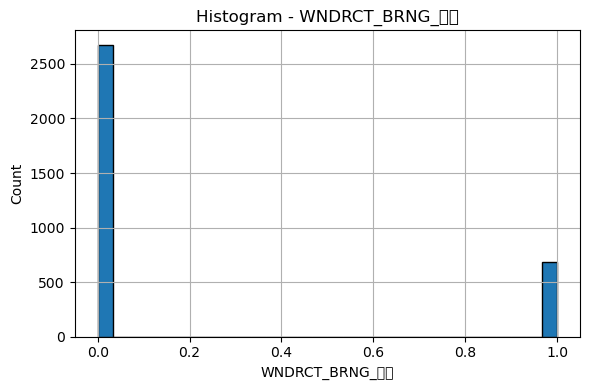

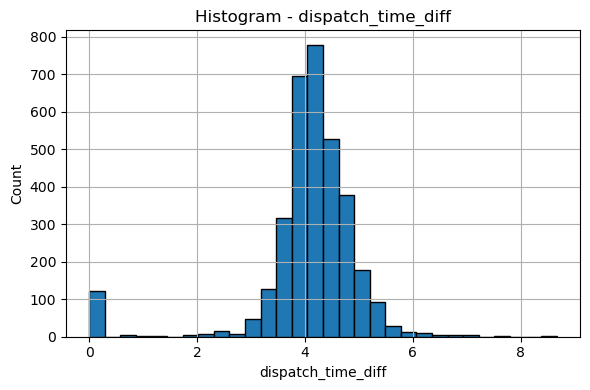

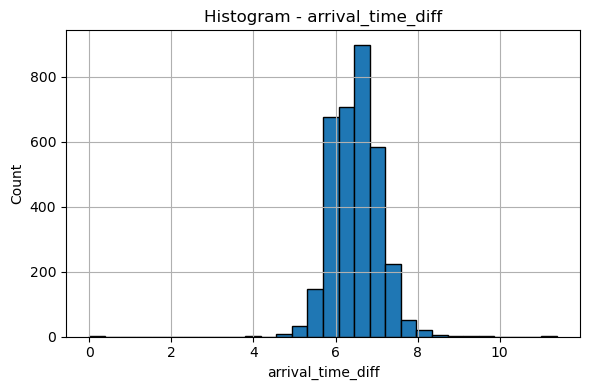

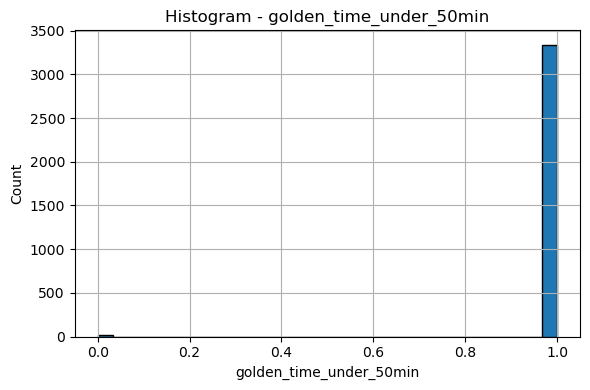

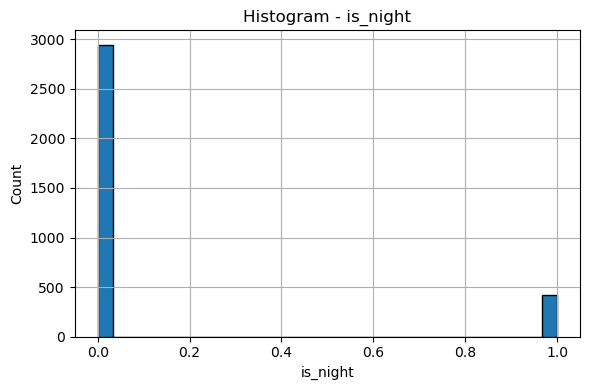

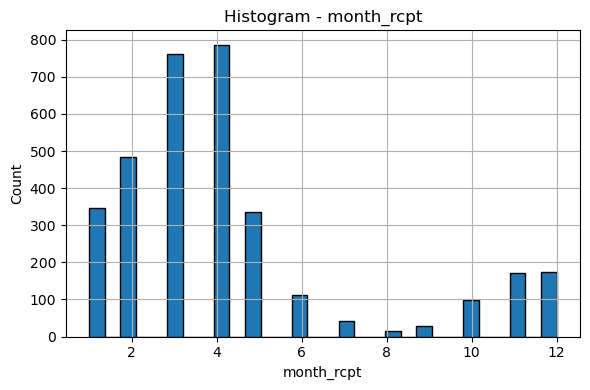

In [21]:
print("\n[STEP1] EDA 요약")
print("자료형 요약:")
print(df.dtypes.value_counts(), "\n")

print("기초통계(숫자형):")
display(df.describe().T)

print("결측치 Top10:")
missing = df.isnull().sum().sort_values(ascending=False)
display(missing.head(10))

print("\n수치형 변수 히스토그램")

numeric_cols = df.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    df[col].hist(bins=30, edgecolor="black")
    plt.title(f"Histogram - {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

In [22]:
print("\n[STEP2] GridSearchCV (RandomForest, 작은 탐색공간, RMSE 커스텀 스코어)")

def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse_score, greater_is_better=False)  # 작을수록 좋음 → 음수로 처리

param_grid = {
    "n_estimators":      [300, 600],
    "max_depth":         [None, 12, 20],
    "min_samples_leaf":  [1, 2, 4],
    "min_samples_split": [2, 4, 8],
    "max_features":      ["sqrt", "log2"]
}

grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=3,
    n_jobs=-1,
    verbose=0
)
grid.fit(X, y)

best_params = grid.best_params_
best_rmse_cv = -grid.best_score_  # 부호 반전

print("Best Params:", best_params)
print(f"Best CV RMSE: {best_rmse_cv:.4f}")



[STEP2] GridSearchCV (RandomForest, 작은 탐색공간, RMSE 커스텀 스코어)
Best Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 300}
Best CV RMSE: 1.3439


In [23]:
print("\n[STEP3] 10회 반복 학습 (각각 5-Fold CV), 6:2:2 분할 / Test 고정")

# Test 20% 고정
X_rem, X_test, y_rem, y_test = train_test_split(
    X, y, test_size=0.2, random_state=TEST_SPLIT_SEED, shuffle=True
)

records = []

for i, seed in enumerate(SEEDS, start=1):
    # Train:Val = 6:2 (즉, 남은 80%에서 75:25)
    X_train, X_val, y_train, y_val = train_test_split(
        X_rem, y_rem, test_size=0.25, random_state=seed, shuffle=True
    )

    # 5-Fold CV on Train
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    rmse_cv, mae_cv, r2_cv = [], [], []

    for tr_idx, va_idx in kf.split(X_train):
        model_cv = RandomForestRegressor(random_state=seed, n_jobs=-1, **best_params)
        model_cv.fit(X_train.iloc[tr_idx], y_train[tr_idx])
        pred_cv = model_cv.predict(X_train.iloc[va_idx])
        rmse_cv.append(rmse(y_train[va_idx], pred_cv))
        mae_cv.append(mean_absolute_error(y_train[va_idx], pred_cv))
        r2_cv.append(r2_score(y_train[va_idx], pred_cv))

    # 최종 재학습 (Train+Val = 80%) 후, 고정 Test 평가
    X_fit = pd.concat([X_train, X_val], axis=0)
    y_fit = np.concatenate([y_train, y_val], axis=0)

    model = RandomForestRegressor(random_state=seed, n_jobs=-1, **best_params)
    model.fit(X_fit, y_fit)

    pred_test = model.predict(X_test)
    rmse_test = rmse(y_test, pred_test)
    mae_test  = mean_absolute_error(y_test, pred_test)
    r2_test   = r2_score(y_test, pred_test)

    rec = {
        "seed": seed,
        "rmse_cv": np.mean(rmse_cv),
        "mae_cv":  np.mean(mae_cv),
        "r2_cv":   np.mean(r2_cv),
        "rmse_test": rmse_test,
        "mae_test":  mae_test,
        "r2_test":   r2_test
    }
    records.append(rec)
    print(f"Run {i:>2}/10 (seed={seed}) → "
          f"RMSE={rmse_test:.4f}, MAE={mae_test:.4f}, R²={r2_test:.4f}")

df_runs = pd.DataFrame(records)
print("\n개별 결과 미리보기:")
display(df_runs.head())

print("\n=== [STEP3 요약: Test 성능 평균 ± 표준편차] ===")
for m in ["rmse_test", "mae_test", "r2_test"]:
    mean, std = df_runs[m].mean(), df_runs[m].std()
    label = m.replace("_test","").upper()
    print(f"{label:>4} = {mean:.4f} ± {std:.4f}")



[STEP3] 10회 반복 학습 (각각 5-Fold CV), 6:2:2 분할 / Test 고정
Run  1/10 (seed=40) → RMSE=1.3128, MAE=0.8821, R²=0.1818
Run  2/10 (seed=41) → RMSE=1.3135, MAE=0.8848, R²=0.1809
Run  3/10 (seed=43) → RMSE=1.3101, MAE=0.8826, R²=0.1851
Run  4/10 (seed=44) → RMSE=1.3116, MAE=0.8840, R²=0.1834
Run  5/10 (seed=45) → RMSE=1.3121, MAE=0.8827, R²=0.1826
Run  6/10 (seed=46) → RMSE=1.3138, MAE=0.8858, R²=0.1805
Run  7/10 (seed=47) → RMSE=1.3090, MAE=0.8799, R²=0.1865
Run  8/10 (seed=48) → RMSE=1.3186, MAE=0.8895, R²=0.1745
Run  9/10 (seed=49) → RMSE=1.3120, MAE=0.8841, R²=0.1828
Run 10/10 (seed=50) → RMSE=1.3126, MAE=0.8845, R²=0.1820

개별 결과 미리보기:


,seed,rmse_cv,mae_cv,r2_cv,rmse_test,mae_test,r2_test
0,40,1.267159,0.851535,0.151751,1.312812,0.882096,0.181784
1,41,1.299327,0.877575,0.152785,1.313506,0.884837,0.180919
2,43,1.359690,0.893868,0.137964,1.310118,0.882625,0.185139
3,44,1.310698,0.869482,0.156316,1.311554,0.884028,0.183352
4,45,1.367002,0.903160,0.125384,1.312149,0.882695,0.182610



=== [STEP3 요약: Test 성능 평균 ± 표준편차] ===
RMSE = 1.3126 ± 0.0026
 MAE = 0.8840 ± 0.0025
  R2 = 0.1820 ± 0.0032


In [24]:
print("\n[STEP4] Feature Importance Top 10 (Train+Val로 재학습, seed=42)")

model_imp = RandomForestRegressor(random_state=42, n_jobs=-1, **best_params)
model_imp.fit(X_rem, y_rem)   # 80% (Train+Val)만 사용

importances = model_imp.feature_importances_
idx = np.argsort(importances)[::-1][:10]

fi_table = pd.DataFrame({
    "feature": X.columns[idx],
    "importance": importances[idx]
})
display(fi_table.reset_index(drop=True))



[STEP4] Feature Importance Top 10 (Train+Val로 재학습, seed=42)


,feature,importance
0,DSPT_REQ_HR,0.089578
1,arrival_time_diff,0.088225
2,FRSTN_GRNDS_DSTNC,0.083594
3,CNTR_GRNDS_DSTNC,0.078991
4,HR_UNIT_ARTMP,0.066663
5,HR_UNIT_HUM,0.063496
6,dispatch_time_diff,0.060518
7,CTPV_NM_gyeonggi,0.039319
8,month_rcpt,0.038439
9,MONTH,0.037473


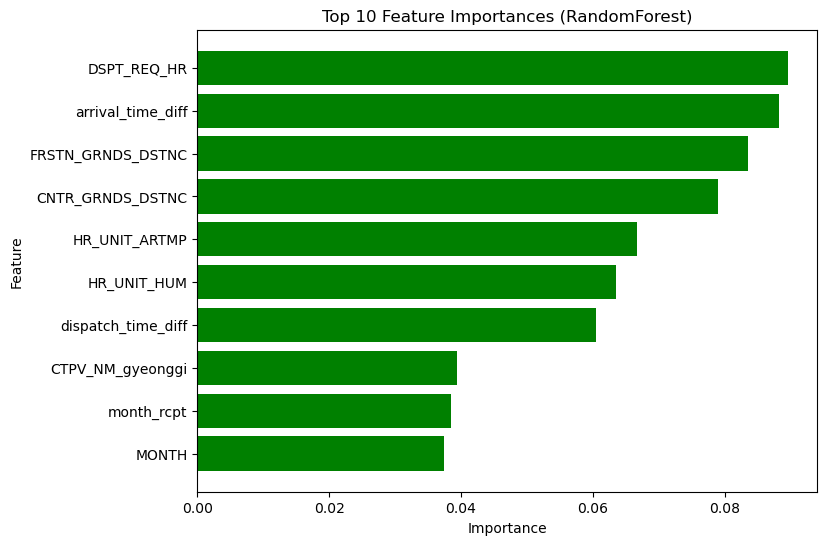

In [25]:
import matplotlib.pyplot as plt

# 중요도 상위 10개만 선택
top_n = 10
fi_sorted = fi_table.sort_values("importance", ascending=False).head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(fi_sorted["feature"], fi_sorted["importance"], color="Green")
plt.gca().invert_yaxis()  # 가장 중요한 게 위로 오도록
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title(f"Top {top_n} Feature Importances (RandomForest)")
plt.show()
#plt.savefig("fi_top10_rf.png", dpi=300, bbox_inches="tight")  # ★ 저장

In [26]:
print("\n[STEP5] SHAP Top 10")

import shap
# 최종 해석은 Train+Val로 학습된 모델 기준
explainer = shap.TreeExplainer(model_imp)

# Test에서 2000행 샘플 (부족하면 전부 사용)
sample_n = min(2000, len(X_test))
X_sample = X_test.sample(sample_n, random_state=42)

shap_values = explainer.shap_values(X_sample)   # (n_sample, n_features)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
idx = np.argsort(mean_abs_shap)[::-1][:10]

shap_table = pd.DataFrame({
    "feature": X.columns[idx],
    "mean_|SHAP|": mean_abs_shap[idx]
})
display(shap_table.reset_index(drop=True))



[STEP5] SHAP Top 10


,feature,mean_|SHAP|
0,CTPV_NM_gyeonggi,0.117851
1,CNTR_GRNDS_DSTNC,0.102836
2,FRSTN_GRNDS_DSTNC,0.101799
3,CMBS_EXPOBJ_LCLSF_NM_nan,0.071356
4,FND_IGTN_PSTN_NM_under,0.061134
5,CMBS_EXPOBJ_LCLSF_NM_PAPER_WOOD,0.052428
6,DSPT_REQ_HR,0.049155
7,IGTN_HTSRC_NM_unknown,0.047466
8,HR_UNIT_HUM,0.046606
9,arrival_time_diff,0.044515


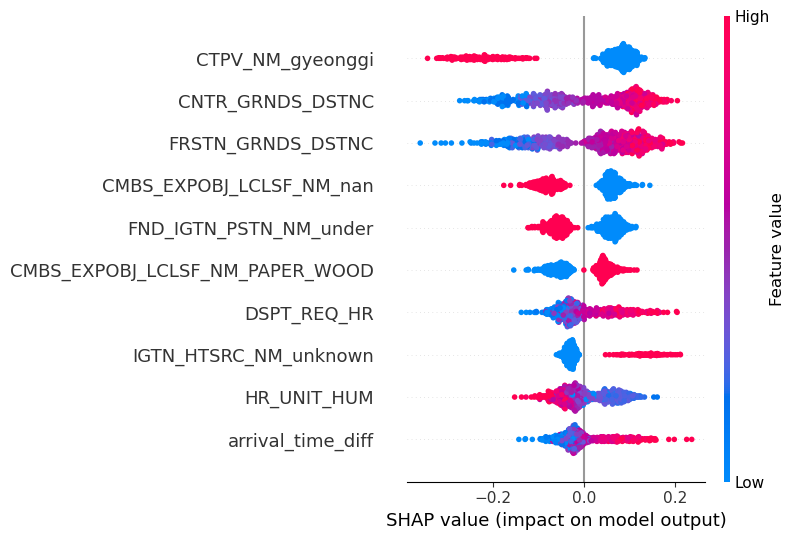

In [27]:
# 빨강(특징값 큼) / 파랑(작음) 색상으로 영향 방향까지 함께 보이는 대표 플롯
shap.summary_plot(
    shap_values,
    X_sample,
    max_display=10,         # 상위 10개
    show=True
)
